# Open PhenoLiDAR demo notebook
This notebook shows the structure of the HDF5 files stored by Open PhenoLiDAR and basic data processing

## Import required libraries
You need to make sure that you have installed the required libraries. See the links for further references and instructions:
* [PyTables](https://www.pytables.org/)
* [Pandas](https://pandas.pydata.org/)
* [PyntCloud](https://pyntcloud.readthedocs.io/en/latest/)
* [pythreejs](https://github.com/jupyter-widgets/pythreejs) to visualize the point clouds in 3D (you may also need to manually activate it as described in the instructions)

In [1]:
%pylab inline
import tables
import pandas as pd
from pyntcloud import PyntCloud

Populating the interactive namespace from numpy and matplotlib


## Load the HDF file using PyTables
By default, the files will be stores in the `../demo_data/h5_files/` folder. You can use TAB to autofill

In [2]:
h5_file = tables.open_file('../demo_data/h5_files/Test/Test_20210609_161057.h5')

## File structure
The H5 is structured in the following datasets
* `/odom` with the odometry from MAVROS
* `/points` the actual point cloud in odometry coordinates
* `/scans` the raw LiDAR scans

PyTables allows indexing, so it is possible to subset the data: [:10000] to load the first 10.000 scans

In [3]:
h5_file

File(filename=../demo_data/h5_files/Test/Test_20210609_161057.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=1, complib='blosc:lz4', shuffle=True, bitshuffle=False, fletcher32=True, least_significant_digit=None))
/ (RootGroup) ''
/odom (Table(7644,), fletcher32, shuffle, blosc:lz4(1)) 'Odometry'
  description := {
  "ts": Time64Col(shape=(), dflt=0.0, pos=0),
  "tx": Float32Col(shape=(), dflt=0.0, pos=1),
  "ty": Float32Col(shape=(), dflt=0.0, pos=2),
  "tz": Float32Col(shape=(), dflt=0.0, pos=3),
  "qw": Float32Col(shape=(), dflt=0.0, pos=4),
  "qx": Float32Col(shape=(), dflt=0.0, pos=5),
  "qy": Float32Col(shape=(), dflt=0.0, pos=6),
  "qz": Float32Col(shape=(), dflt=0.0, pos=7)}
  byteorder := 'little'
  chunkshape := (1820,)
/points (Table(791885,), fletcher32, shuffle, blosc:lz4(1)) 'PointCloud'
  description := {
  "x": Float32Col(shape=(), dflt=0.0, pos=0),
  "y": Float32Col(shape=(), dflt=0.0, pos=1),
  "z": Float32Col(shape=(), dflt=0.0, pos=2),
  "intensity":

## Show the scans as a raster
The scans can be shown as a raster image

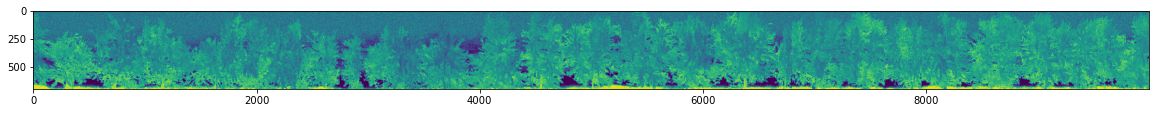

In [4]:
fig, ax = plt.subplots(1,1, figsize=(20,15))
ax.imshow(h5_file.root.scans[:10000]["ranges"].transpose())

## Display the Point Cloud
To display the data, we create a pandas dataframe before loading into PyntCloud. 
The structure of the dataframe is quite simple, with the x,y,z coordinates, intensities and scan index (0-699 in the LMS400)

In [5]:
df_points = pd.DataFrame.from_records(h5_file.root.points[:])
df_points

,x,y,z,intensity,index
0,-0.454581,2.206940,1.687440,0.0,0
1,0.141035,2.339505,2.028530,2.0,3
2,0.725754,2.469410,2.354878,2.0,6
3,-0.269720,2.247592,1.775421,0.0,7
4,-0.949453,2.096070,1.377599,2.0,11
...,...,...,...,...,...
791880,1.116826,0.091209,-1.915181,10.0,694
791881,1.168630,0.071398,-1.868970,10.0,695
791882,1.346351,0.003533,-1.691672,6.0,696
791883,1.269761,0.032727,-1.778080,4.0,697


With the dataframe we can use pandas functionality for plotting histograms for intensity or height

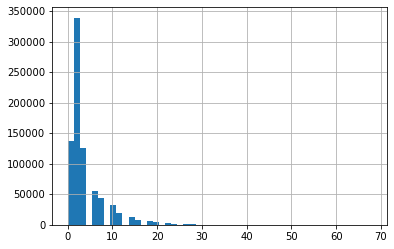

In [6]:
df_points.intensity.hist(bins=50)

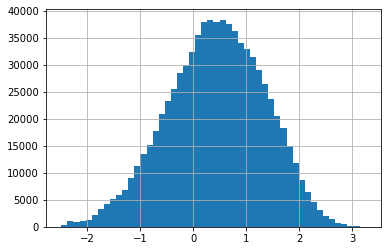

In [7]:
df_points.z.hist(bins=50)

## Convert the dataframe into a PyntCloud object
The dataframe can be easiily converte into a PyntCloud object for display and further functionality (filtering, voxels, etc)

In [8]:
cloud = PyntCloud(df_points)

### Plotting the cloud
The cloud can be easly displayed in the notebook. If `pythreejs` is installed you can enjoy a nice interactive display.

Depending on the light conditions, the cloud can be very noisy and needs filtering.

In [9]:
cloud.plot(initial_point_size=0.01, use_as_color='z', cmap='jet', vmax=10)

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-5.748703956604004, 71.69467735290527, 5.307…

## Cloud filtering
Stray points have low intensities, so we can do a first filter based on intensity. We can use pandas and load it back as a PyntCloud object.

In [10]:
df_points_clean = df_points[df_points.intensity>4]
cloud_clean = PyntCloud(df_points_clean)
cloud_clean.plot(initial_point_size=0.01, use_as_color='z', cmap='jet', vmax=10)

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-5.753989219665527, 71.30402755737305, 5.032…

## Statistical Outlier Removal

The SOR filter can be applied very easitly with PyntCloud for further filtering of outliers.

In [11]:
kdtree = cloud_clean.add_structure("kdtree")
f=cloud_clean.get_filter('SOR', kdtree_id=kdtree, k=2, z_max=0.5)
cloud_clean.apply_filter(f)

[ 1.35739681  1.35739681  2.96646755 ...  0.27823853 -0.14002139
  5.51140051]


In [12]:
cloud_clean.plot(initial_point_size=0.01, use_as_color='z', cmap='jet', vmax=10)

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-5.745692253112793, 71.22573852539062, 4.065…

## Create and display voxels

In [13]:
voxelgrid_id = cloud_clean.add_structure('voxelgrid', size_x=0.1, size_y=0.1, size_z=0.1, regular_bounding_box=False)
voxelgrid = cloud_clean.structures[voxelgrid_id]
voxelgrid.plot(d=3, mode="z_max", cmap="jet")

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(79.98221588134766, 744.0117492675781, 107.69…

## Plot the trajectory
As with the point clouds, we can load the odometry as a dataframe and plot the trajectory

In [14]:
df_odom = pd.DataFrame.from_records(h5_file.root.odom[:])
df_odom

,ts,tx,ty,tz,qw,qx,qy,qz
0,1.748450e+09,-1.178615,1.545762,-0.119673,0.632259,0.001034,0.021044,0.774470
1,1.758389e+09,-1.181222,1.558071,-0.118037,0.633433,0.001271,0.020421,0.773527
2,1.768432e+09,-1.183969,1.570316,-0.116209,0.634872,0.001348,0.019575,0.772368
3,1.778395e+09,-1.187002,1.582372,-0.114371,0.636172,0.001501,0.018698,0.771319
4,1.788389e+09,-1.190374,1.594368,-0.112639,0.637102,0.001709,0.017963,0.770568
...,...,...,...,...,...,...,...,...
7639,9.176724e+08,3.252576,-0.691043,0.306028,0.562791,0.002318,-0.008342,-0.826554
7640,9.276723e+08,3.255460,-0.705149,0.306201,0.561047,0.001917,-0.007734,-0.827746
7641,9.376691e+08,3.257832,-0.719558,0.305478,0.559673,0.001927,-0.006922,-0.828682
7642,9.476690e+08,3.260386,-0.734334,0.304310,0.558746,0.002265,-0.006063,-0.829314


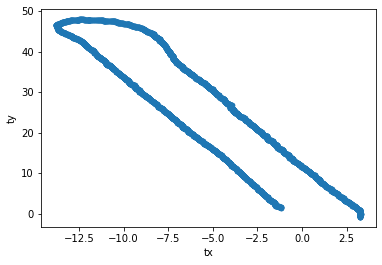

In [15]:
df_odom.plot.scatter(x='tx', y='ty')

## Closing the file
You should close the file when you finish your analysis to prevent data corruption

In [16]:
h5_file.close()